# CAP 6618 - Machine Learning for Computer Vision

## Programming Project 5

In [1]:
# All imports in one place

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import tensorflow as tf
import sys
#import tarfile
from six.moves import urllib
from collections import defaultdict
import matplotlib.image as mpimg
from scipy.misc import imresize
import re
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim
from random import sample
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Function Declarations

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255

def prepare_batch(rps_paths_and_classes, batch_size):
    # sample: Chooses batch_size unique random elements from a population sequence or set.
    batch_paths_and_classes = sample(rps_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch


plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12





    


### Rock Paper Scissors dataset has been already downloaded to: datasets\rock_paper_scissors

### I combined the test folder with the training folder to have one folder of images. That way, I can reuse more of the existing code from CAP6618_PP5 as possible.

In [3]:
rps_classes = ['rock', 'paper', 'scissors']
rps_root_path = os.path.join("datasets", "rock_paper_scissors")

#### Get the list of all the image file paths for each class

In [4]:
image_paths = defaultdict(list)

for rps_class in rps_classes:
    image_dir = os.path.join(rps_root_path, rps_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".png"):
            image_paths[rps_class].append(os.path.join(image_dir, filepath))            

#### Sort the image paths just to make this notebook behave consistently across multiple runs

In [5]:
for paths in image_paths.values():
    paths.sort() 

#### Take a peek at a few samples per class.

Class: rock


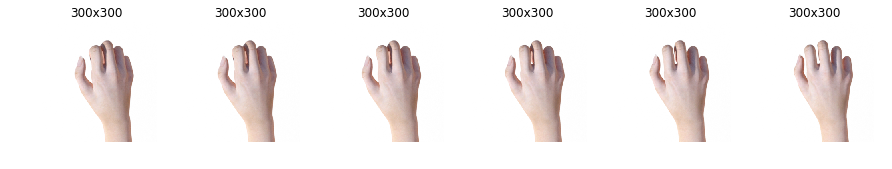

Class: paper


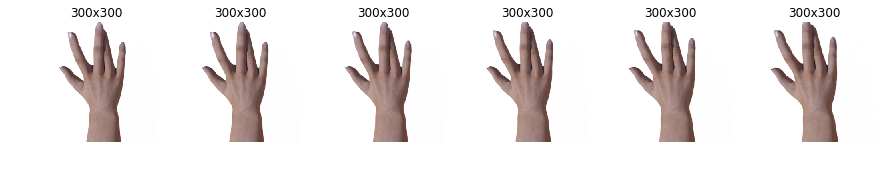

Class: scissors


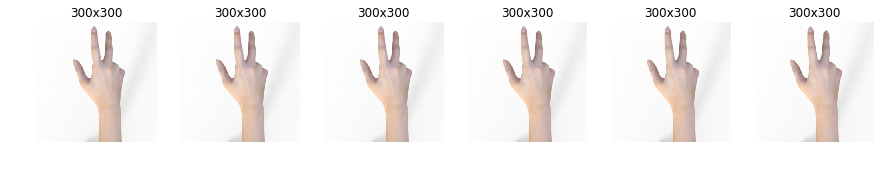

In [6]:
n_examples_per_class = 6

width = 299
height = 299
channels = 3

for rps_class in rps_classes:
    print("Class:", rps_class)
    plt.figure(figsize=(15,10))
    for index, example_image_path in enumerate(image_paths[rps_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

#### Verify that prepare_image works. We need the images to be 299x299

C:\Users\Gabor\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


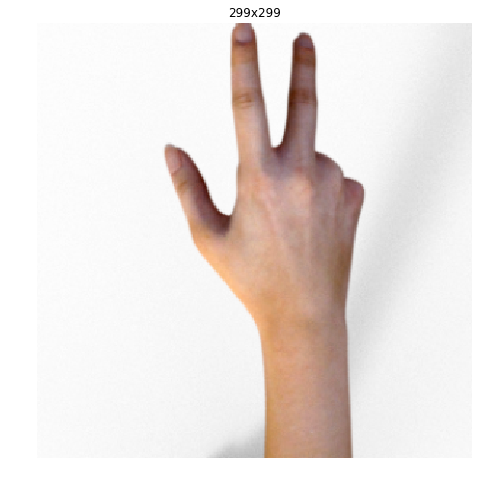

In [7]:
example_of_prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(example_of_prepared_image)
plt.title("{}x{}".format(example_of_prepared_image.shape[1], example_of_prepared_image.shape[0]))
plt.axis("off")
plt.show()

### Load pre-trained Inception v3

In [8]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)
    
fetch_pretrained_inception_v3()

### Setup tf variables, etc.

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")

training = tf.placeholder_with_default(False, shape=[])

# Returns:
#   logits: the pre-softmax activations, a tensor of size [batch_size, num_classes]
#   end_points: a dictionary from components of the network to the corresponding activation.
    
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# Removes the dimensions of size 1 on given axis

prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

### Add the final fully connected layer on top of this layer:

In [11]:
n_outputs = len(rps_classes)

with tf.name_scope("new_output_layer"):
    rps_logits = tf.layers.dense(prelogits, n_outputs, name="rps_logits")
    Y_proba = tf.nn.softmax(rps_logits, name="Y_proba")

Instructions for updating:
Use keras.layers.dense instead.


In [12]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=rps_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
    rps_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="rps_logits")
    training_op = optimizer.minimize(loss, var_list=rps_vars)

with tf.name_scope("eval"):
    # Says whether the targets are in the top K predictions.
    # The targets argument to tf.nn.in_top_k(predictions, targets, k) must be a vector of class IDs 
    # (i.e. indices of columns in the predictions matrix). 
    # This means that it only works for single-class classification problems.
    correct = tf.nn.in_top_k(rps_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
[v.name for v in rps_vars]

['rps_logits/kernel:0', 'rps_logits/bias:0']

### Split the dataset

In [13]:
rps_class_ids = {rps_class: index for index, rps_class in enumerate(rps_classes)}
rps_class_ids

{'rock': 0, 'paper': 1, 'scissors': 2}

In [14]:
rps_paths_and_classes = []
for rps_class, paths in image_paths.items():
    for path in paths:
        rps_paths_and_classes.append((path, rps_class_ids[rps_class]))
        

test_ratio = 0.1
train_size = int(len(rps_paths_and_classes) * (1 - test_ratio)) # Number of records(rps) to train on

np.random.shuffle(rps_paths_and_classes)

rps_paths_and_classes_train = rps_paths_and_classes[:train_size]
rps_paths_and_classes_test = rps_paths_and_classes[train_size:]

print(rps_paths_and_classes_train[:3])
print("Training images: ", len(rps_paths_and_classes_train))
print("Test images: ", len(rps_paths_and_classes_test))

[('datasets\\rock_paper_scissors\\scissors\\testscissors02-051.png', 2), ('datasets\\rock_paper_scissors\\rock\\rock03-058.png', 0), ('datasets\\rock_paper_scissors\\scissors\\testscissors01-078.png', 2)]
Training images:  2602
Test images:  290


### Test batching system

In [19]:
X_batch, y_batch = prepare_batch(rps_paths_and_classes_train, batch_size=4)
X_test, y_test = prepare_batch(rps_paths_and_classes_test, batch_size=len(rps_paths_and_classes_test))

C:\Users\Gabor\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [20]:
print("X_batch.shape", X_batch_testing.shape)
print("X_batch.dtype", X_batch_testing.dtype)
print("y_batch.shape", y_batch_testing.shape)
print("y_batch.dtype", y_batch_testing.dtype)
print("X_test.shape", X_test_testing.shape)

X_batch.shape (4, 299, 299, 3)
X_batch.dtype float32
y_batch.shape (4,)
y_batch.dtype int32
X_test.shape (290, 299, 299, 3)


### Train the model

In [17]:
n_epochs = 8
batch_size = 40
n_iterations_per_epoch = len(rps_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            # X_batch should have a batch of training examples and y_batch should be the labels for those images
            X_batch, y_batch = prepare_batch(rps_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_rps_model")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
Epoch 0.

C:\Users\Gabor\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


................................................................  Train accuracy: 0.375
Epoch 1.................................................................  Train accuracy: 0.55
Epoch 2.................................................................  Train accuracy: 0.575
Epoch 3.................................................................  Train accuracy: 0.55
Epoch 4.................................................................  Train accuracy: 0.525
Epoch 5.................................................................  Train accuracy: 0.65
Epoch 6.................................................................  Train accuracy: 0.625
Epoch 7.................................................................  Train accuracy: 0.575


###  Evaluate the model

In [21]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_rps_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_rps_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.6137931
